# Parsing y exploración de los datos

Parseamos el archivo csv que contiene notas del diario: "La Nación" y a continuación imprimimos una nota y su categoría para ver la forma de los datos.

In [ ]:
%matplotlib inline
# import csv

from os.path import expanduser
import numpy as np

home = expanduser("~")

X = []
y = []


import csv

def unicode_csv_reader(utf8_data, dialect=csv.excel, **kwargs):
    csv_reader = csv.reader(utf8_data, dialect=dialect, **kwargs)
    for row in csv_reader:
        yield [unicode(cell, 'utf-8') for cell in row]

filename = home + "/projects/aa/tp1/notas_ln.csv"
reader = unicode_csv_reader(open(filename))
for i, field in enumerate(reader):
    if i != 0:
        X.append( field[3] )
        y.append( field[2] )

X = np.array(X)
y = np.array(y)

In [2]:
print X[-2]
print "----------"
print "Categoría:", y[-2]

La plataforma de video on line de Google anunció YouTube Gaming, su servicio de transmisión de transmisión en vivo y bajo demanda de las partidas de videojuegos. De esta forma, la compañía de Internet entra a competir de forma directa con Twitch, la plataforma predilecta de los aficionados para relatar y comentar sus sesiones en sus juegos preferidos.YouTube Gaming funcionará de forma independiente del resto de los contenidos de video on line, y estará disponible desde fines de junio en Estados Unidos y Reino Unido. Las sugerencias en los resultados de las consulta dentro de este servicio estarán relacionadas con los títulos más destacados. Como ejemplo, la compañía dijo que una búsqueda que inicie con el término "Call" ofrecerá como respuesta "Call of Duty"  en vez de "Call me maybe", el hit de la cantante Carly Rae Jepsen.El anuncio de YouTube Gaming y la respuesta de TwitchYouTube Gaming contará con 25.000 videos de transmisiones y partidas producidas tanto por aficionados como por 

Primero, separamos los datos en dos conjuntos: Desarrollo y Validación (por si fuese necesario presentar resultados finales además del análisis de los distintos algoritmos).

In [3]:
from sklearn import cross_validation

X_development, X_validation, y_development, y_validation = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0) 
print "Cantidad de datos de desarrollo:", X_development.shape[0]

# Ya que no utilizaremos estos datos en este trabajo, liberamos la memoria
X_validation = []  
y_validation = []  
X = []

Cantidad de datos de desarrollo: 14923


Vemos ahora la cantidad de documentos por categoría para ver el balance de los datos:

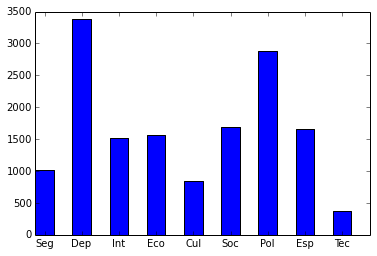

In [4]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


labels, values = zip(*Counter(y_development).items())

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, [lab[0:3] for lab in labels])
plt.show()



# Clasificación automática

Para clasificar este tipo de documentos, necesitamos extraer **Features**, para ello, utilizaremos la técnica conocida como **Bag of Words**:

Bag of Words se refiere al proceso de convertir documentos de texto en vectores numéricos de features ([ver documentación](http://scikit-learn.org/stable/modules/feature_extraction.html)) utilizando la estrategia de Tokenizar, Contar y luego Normalizar. Utilizando este mecanismo, cada documento queda descripto como las ocurrencias de sus palabras y se ignora el orden relativo dentro de este.

### Primer acercamiento: CountVectorizer

Para la implementación, utilizaremos el módulo `sklearn.feature_extraction.text.CountVectorizer`

La documentación indica: 
*Convert a collection of text documents to a matrix of token counts.*
*This implementation produces a sparse representation of the counts using scipy.sparse.coo_matrix.*
*If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.*

En primera instancia utilizaremos los valores por defecto y luego compararemos la performance al agregar características específicas al algoritmo.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_vectorized = vectorizer.fit_transform(X_development)

In [6]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vectorized, y_development, test_size=0.2, random_state=1) 
print "Train:", X_train.shape, " Test:", X_test.shape

Train: (11938, 147629)  Test: (2985, 147629)


Luego de aplicar la vectorización y separar en datos de training y test, vemos que quedan aproximadamente 12.000 documentos para entrenamiento y 3.000 datos para testeo en donde cada uno contiene 147.600 features (uno por cada palabra del vocabulario). 

### Clasificador: Naive Bayes (multinomial)

A continuación, utilizaremos el algoritmo `sklearn.naive_bayes.MultinomialNB` para clasificar con los parámetros por defecto e imprimimos la matriz de confusión (en la diagonal, aciertos para cada clase, mientras menos valores fuera de la diagonal mejor)

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print cm

[[ 86   0   5  12   6  27   0  26   0]
 [  3 697   3   0   1  11   1   9   0]
 [  2   3 241   2   3  21   0  28   1]
 [  8   7   1 216   2   5   5  54   0]
 [  5   1  16   1 284   2   6  23   0]
 [  8   0   7   1   4 531   3   2   0]
 [  2   2   0   1   1  19 164  17   0]
 [  9   5  18   7  10  15   9 254   2]
 [  0   1   6   0   7   2   0  32  22]]


Luego, veremos una posible métrica para analizar estos resultados. En este caso utilizamos el score `f1` calculado como 

$F1 = 2 * (precision * recall) / (precision + recall)$

Para evitar un mal resultado debido a la falta de balanceo de los datos, utilizaremos el parametro `average` con el siguiente valor: 

***'weighted':***
    *Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.*


In [8]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

0.83421675183677424

## Stop Words

Hay ciertas palabras que no agregan información para el estudio, por ejemplo las llamadas *stopwords*: palabras comunes que no contienen significancia para ser utilizadas (en general en search queries). 

Veamos qué ocurre al eliminarlas en nuestro `CountVectorizer`

In [9]:
from nltk.corpus import stopwords
vectorizer = CountVectorizer(stop_words= stopwords.words('spanish'))

X_vectorized = vectorizer.fit_transform(X_development)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vectorized, y_development, test_size=0.2, random_state=1) 
print "Train:", X_train.shape, " Test:", X_test.shape


Train: (11938, 147355)  Test: (2985, 147355)


In [10]:
clf = MultinomialNB().fit(X_train,y_train)
y_pred = clf.predict(X_test)

confusion_matrix(y_test,y_pred)

array([[ 91,   0,   5,  13,   5,  24,   0,  24,   0],
       [  3, 702,   3,   0,   1,   7,   1,   8,   0],
       [  3,   3, 246,   2,   3,  18,   0,  23,   3],
       [  6,   6,   1, 236,   2,   3,   6,  38,   0],
       [  5,   0,  17,   1, 286,   1,   6,  22,   0],
       [ 10,   0,   9,   1,   5, 527,   3,   1,   0],
       [  3,   2,   0,   1,   1,  15, 170,  14,   0],
       [  8,   6,  17,   8,   9,   9,  11, 259,   2],
       [  0,   1,   6,   0,   6,   2,   0,  26,  29]])

In [11]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

0.85180574707305934

Puede verse que la performance del modelo mejora un poco.  

## Otras estrategias

#### TF-IDF (term-frequency times inverse document-frequency.)
Ya que contar las palabras puede producir un exceso en palabras muy frecuentes con poca información, es posible utilizar la ténica `TF-IDF` que normaliza las frecuencias en el rango 0-1.  

La documentación indica: *As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model*

Veremos entonces qué ocurre al entrenar utilizando esta técnica.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
X_vectorized = vectorizer.fit_transform(X_development)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vectorized, y_development, test_size=0.2, random_state=1) 
print "Train:", X_train.shape, " Test:", X_test.shape

Train: (11938, 147629)  Test: (2985, 147629)


In [13]:
clf = MultinomialNB().fit(X_train,y_train)
y_pred = clf.predict(X_test)

confusion_matrix(y_test,y_pred)

array([[  0,  66,   2,   5,   0,  88,   0,   1,   0],
       [  0, 716,   1,   0,   0,   8,   0,   0,   0],
       [  0,  27, 138,   1,   0, 132,   0,   3,   0],
       [  0, 193,   0,  72,   0,  32,   0,   1,   0],
       [  0,  72,  18,   0,  77, 171,   0,   0,   0],
       [  0,   2,   0,   0,   0, 554,   0,   0,   0],
       [  0,  34,   0,   0,   0, 156,  15,   1,   0],
       [  0, 136,   3,   1,   0, 147,   0,  42,   0],
       [  0,  25,   2,   0,   0,  39,   0,   4,   0]])

In [14]:
f1_score(y_test, y_pred, average='weighted')

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.45752497704187023

Como puede observarse, la performance del sistema decae notablemente. Este proceso puede deberse a que las categorías estén determinadas fuertemente por la repetición de pocas palabras claves y no por un conjunto más diverso en donde en conjunto determinan el tema. 

## Estrategias: Steammizer

In [4]:
import nltk
stemmizer = nltk.stem.snowball.SnowballStemmer("spanish", ignore_stopwords=True)
    
X_stemmed = []
for sentence in X_development:
    X_stemmed.append(" ".join([stemmizer.stem(x) for x in sentence.split(" ")]))


Una vez que se tienen los stems de cada palabra, procedemos utilizando el CountVectorizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

vectorizer = CountVectorizer() 

X_vectorized = vectorizer.fit_transform(X_stemmed)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vectorized, y_development, test_size=0.2, random_state=1) 
print "Train:", X_train.shape, " Test:", X_test.shape

clf = MultinomialNB().fit(X_train,y_train)
y_pred = clf.predict(X_test)

print confusion_matrix(y_test,y_pred)

print f1_score(y_test, y_pred, average='weighted')

Train: (11938, 128755)  Test: (2985, 128755)
[[ 84   0   5  10   7  27   0  29   0]
 [  3 695   3   0   2  13   1   8   0]
 [  1   3 243   2   3  23   0  25   1]
 [  9  10   1 204   2   3   5  64   0]
 [  4   0  18   1 279   3   7  26   0]
 [  9   0   7   1   6 527   3   3   0]
 [  2   2   0   1   1  20 163  17   0]
 [  8   7  18   7   9  17   9 252   2]
 [  0   1   5   0  10   2   0  32  20]]
0.824527270258


## Conclusiones
 
 En este trabajo se intentó clasificar notas periodísticas del diario La Nación utilizando la técnica de Bag of Words. 

Para lograrlo, procesamos los documentos utilizando vectorizadores para poder luego aplicar el clasificador Naive Bayes en su versión Multinomial. 

Se comparó la performance del sistema variando entre distintas alternativas de vectorización como ser: CountVectorizer, CountVectorizer con filtro de stopwords, TF-IDF Vectorizer y una versión utilizando un Stemmizer.

Los resultados muestran que la mejor clasificación fue lograda utilizando el contador de palabras más simple. Pensamos que esto se debe a que la utilización de estos vectorizadores más complejos requiere un estudio con más precisión de los datos con los que se entrenan y un ajuste de parámetros más preciso que el utilizado.
